### Notes about the data

cc_struct.data.cc_data(D1, D2, D3, D4, D5). The value designated for each of the 5 dimensions (D1-D5) are as follows:

D1: either tube currents (for uniformity) or the scan steps (for energy/spectral data). This will be a singleton for all other tests and can be squeezed/removed from the array;

D2: Specify which energy bin. 13 bins total (SEC0-SEC5, CC0-CC5, EC);

D3: capture views. Singleton for energy tests with one view (can be squeezed/removed);

D4: pixel rows

D5: pixel columns

So for uniformity the value inserted in D1 (1-12) would give access to the different tube current that were measured (0-25 mA), while for a spectral scan the values correspond to threshold settings in a scan (these values are in DAC values, i.e. non-energy calibrated - the standard gain and offset that can be used to get a first approximation to energy calibration should you want to do that are 0.71keV/DAC level and 4keV respectively).

D2 specify which energy bin we are addressing. The energies are designated 0-5 (i.e. 30-45, 45-60, 60-75, 75-90, 90-105, and 105 keV and up for your threshold settings). SEC or CC refers to charge sharing corrected and non-charge sharing corrected data respectively, and EC are the counts above the lowest threshold in the system.

D3 specify which temporal slice of the data we are addressing, and D4, and D5 pixel row and column to designate specific pixel.


In [8]:
import scipy.io
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd


In [9]:
# folder = r"DATA\\S1160_l181_120kVp_5mA_sd755_10p8Al_0p1Cu_coll10mm_PE2_wstep"
folder = r"DATA\\S1160_l181_120kVp_5mA_sd755_10p8Al_0p1Cu_coll10mm_PE2_wstep_air_norm"
BIN_LABELS = [
    "20 kev",
    "30 kev",
    "50 kev",
    "70 kev",
    "90 kev",
    "120 kev",
    "Sum CC1-CC5",
]

In [10]:
def process_mat_files(bin_id, folder):
    """
    Create heatmaps from the given bin ID and folder.

    Parameters:
    - bin_id (int): The ID of the energy bin.
    - folder (str): The path to the folder containing the .mat files.

    Returns:
    - count_maps_A0 (ndarray): Array of count maps for A0.
    - count_maps_A1 (ndarray): Array of count maps for A1.
    - full_count_map (ndarray): Combined count map for A0 and A1.
    """
    count_maps_A0 = []
    count_maps_A1 = []

    # Iterate through the files in the folder
    for file in os.listdir(folder):
        if file.endswith(".mat"):
            file_path = os.path.join(folder, file)
            mat_file = scipy.io.loadmat(file_path)
            cc_data = mat_file["cc_struct"]["data"][0][0][0][0][0][:][:][:][:][:]
            cc_data = cc_data[:, :, :, :, :]

            cc_data = np.mean(cc_data, axis=2)

            count_map = cc_data[0, bin_id, :, :]

            if file.endswith("A0.mat"):
                # Invert the count map
                count_map = np.flip(count_map, axis=0)
                count_map = np.flip(count_map, axis=1)
                count_maps_A0.append(count_map)
            if file.endswith("A1.mat"):
                count_maps_A1.append(count_map)

    count_maps_A0 = np.array(count_maps_A0)

    count_maps_A0_comb = np.concatenate(count_maps_A0, axis=0)
    count_maps_A1_comb = np.concatenate(count_maps_A1, axis=0)
    full_count_map = np.concatenate([count_maps_A0_comb, count_maps_A1_comb], axis=1)

    return count_maps_A0, count_maps_A1, full_count_map

In [11]:
def clean_ncp(full_count_map, verbose=False):
    # find the dead pixels in full_count_map
    dead_pixels = np.where(full_count_map < 50)
    bright_pixels = np.where(full_count_map > 1e6)
    # manually found ncp
    found_ncp = (np.array([118, 119, 120]), np.array([13, 51, 63]))

    if verbose:
        print(f"{dead_pixels = }")
        print(type(dead_pixels))
        print(f"{bright_pixels = }")
        print(f"{found_ncp[0] = }")

    ncps = (
        np.concatenate([dead_pixels[0], bright_pixels[0], found_ncp[0]]),
        np.concatenate([dead_pixels[1], bright_pixels[1], found_ncp[1]]),)
    # impute the dead pixels with the mean of the surrounding pixels
    for pixel in zip(ncps[0], ncps[1]):
        x, y = pixel
        surrounding_pixels = full_count_map[
            [x - 1, y, x - 1, x - 1, x, x, x + 1, x + 1],
            [y - 1, y - 1, y, y + 1, y - 1, y + 1, y - 1, y],
        ]
        full_count_map[x, y] = np.mean(surrounding_pixels)
    return full_count_map

In [12]:
x_left, x_right = 24, 46
edges_y = np.array([0, 14, 42, 70, 98, 125, 152, 180])
diffs_y = np.diff(edges_y)
y_borders = {
    i: {"top": edges_y[i] + 2, "bot": edges_y[i] + 8} for i in range(len(edges_y))
}
x_borders = {i: {"left": x_left, "right": x_right} for i in range(len(edges_y))}

outside_borders = {"top": 4, "bot": 185, "left": 4, "right": 16}

In [13]:
def create_plotly_heatmaps(map, y_borders, x_borders, outside_borders, color_range=None, figsize=(700, 800)):
    
    if color_range is None:
        color_range = [np.min(map), np.max(map)]
    
    fig = px.imshow(
        map,
        color_continuous_scale="Viridis",
        range_color=color_range,
        labels=dict(x="x", y="y", color="value"),
    )

    fig.update_layout(autosize=False, width=figsize[0], height=figsize[1])
    # draw a rectangle around the cropped region

    for key in y_borders:
        fig.add_shape(
            type="rect",
            x0=x_borders[key]["left"],
            y0=y_borders[key]["top"],
            x1=x_borders[key]["right"],
            y1=y_borders[key]["bot"],
            line=dict(
                color="red",
                width=3,
            ),
        )
    fig.add_shape(
        type="rect",
        x0=outside_borders["left"],
        y0=outside_borders["top"],
        x1=outside_borders["right"],
        y1=outside_borders["bot"],
        line=dict(
            color="purple",
            width=3,
        ),
    )

    # add a title
    fig.update_layout(title_text="Count map")
    
    # adjust the figure size
    fig.update_layout(autosize=False, width=figsize[0], height=figsize[1])

    return fig
    


In [14]:
for i, bin_id in enumerate([0,1,2,3,4,5,6]):
    
    count_maps_A0, count_maps_A1, full_count_map = process_mat_files(bin_id=bin_id, folder=folder)
    full_count_map = clean_ncp(full_count_map, verbose=False)
    heatmap_fig = create_plotly_heatmaps(full_count_map, y_borders, x_borders, outside_borders, 
                                  figsize=(400, 600),
                                #   color_range=[0, 30400]
                               )
    heatmap_fig.update_layout(title=f"{BIN_LABELS[bin_id]}")

    heatmap_fig.show()


## Equations

In [15]:
DENSITY = 4.0 #g/cm^3 according to Prusa's article

def Intensity(x, I0, mu, offset):
    return I0 * np.exp(-mu * x) + offset

def HVL(mu):
    # ln(2)/mu
    return np.log(2)/mu 

def T_mean_to_mu(T_mean, x):
    return -np.log(T_mean)/x

def MFP(mu):
    return 1/mu

def mass_mu(mu, DENSITY):
    return mu/DENSITY

print(HVL(27.11))
print(HVL(4.95))
print(HVL(36.23))

0.025567952067869618
0.14002973344645359
0.019131857040020572


## Data extraction

In [22]:
from scipy.optimize import curve_fit

df = pd.DataFrame() # create an empty dataframe to store the results
# df_params = pd.DataFrame(columns=["bin_id", "bin_label", "I0", "mu", "offset", "I0_err", "mu_err", "offset_err"])
thickness = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

bin_range = [0,1,2,3,4,6]
for i, bin_id in enumerate(bin_range):
    df_bin = pd.DataFrame()
    
    # skip bin_id 5
    if bin_id == 5:
        continue

    count_maps_A0, count_maps_A1, full_count_map = process_mat_files(
        bin_id=bin_id, folder=folder
    )
    full_count_map = clean_ncp(full_count_map)
    box_mean = []
    box_std = []
    box_median = []
    for key in y_borders:
        # print(key)
        y_top, y_bot = y_borders[key]["top"], y_borders[key]["bot"]
        x_left, x_right = x_borders[key]["left"], x_borders[key]["right"]
        box_count = full_count_map[y_top:y_bot, x_left:x_right]
        box_mean.append(np.mean(box_count))
        box_std.append(np.std(box_count))
        box_median.append(np.median(box_count))

    # "outside" refers to the region outside the tungsten piece
    outside_counts = full_count_map[
        outside_borders["top"] : outside_borders["bot"],
        outside_borders["left"] : outside_borders["right"],
    ]
    outside_mean = [np.mean(outside_counts)]
    outside_std = [np.std(outside_counts)]
    outside_median = [np.median(outside_counts)]

    # concatentate outside_mean and box mean
    T_mean = outside_mean + box_mean[::-1]
    T_mean_norm = T_mean / T_mean[0]
    T_std = outside_std + box_std[::-1]
    
    df_bin["bin_id"] = np.repeat(bin_id, len(thickness))
    df_bin["bin_label"] = np.repeat(BIN_LABELS[bin_id], len(thickness))
    df_bin["thickness"] = thickness
    df_bin["T_mean"] = T_mean
    df_bin["T_mean_norm"] = T_mean_norm
    df_bin["T_std"] = T_std
    df_bin["T_error"] = T_std/np.sqrt(len(T_std))
    df_bin["T_relative_error"] = [err/mean for err, mean in zip(T_std, T_mean)]

    # curve fit to get the attenuation coefficient
    popt, pcov = curve_fit(Intensity, thickness, T_mean, sigma=T_std, 
                           p0=[T_mean[0], 0.9, 0]
                           )
    I0, mu, offset = popt
    I0_err, mu_err, offset_err = np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2])
    hvl = HVL(mu)
    mfp = MFP(mu)
    mu_mass = mass_mu(mu, DENSITY)  
    
    df_bin["I0_fit"] = np.repeat(I0, len(thickness))
    df_bin["I0_err"] = np.repeat(I0_err, len(thickness))
    df_bin["mu_fit"] = np.repeat(mu, len(thickness))
    df_bin["mu_err"] = np.repeat(mu_err, len(thickness))
    df_bin["offset_fit"] = np.repeat(offset, len(thickness))
    df_bin["offset_err"] = np.repeat(offset_err, len(thickness))
    
    df_bin = df_bin.round(3)
    df = pd.concat([df, df_bin])

    row = pd.DataFrame({
        "bin_id": bin_id,
        "bin_label": BIN_LABELS[bin_id],
        "I0 [counts]": I0,
        "mu [mm^-1]": mu,
        "offset [counts]": offset,
        "I0_err": I0_err,
        "mu_err": mu_err,
        "offset_err": offset_err,
        "HVL [mm]": hvl,
        "MFP [mm]": mfp,
        "mu_mass": mu_mass
    }, index=[0])
    
    if bin_id == 0:
        df_params = row
    else:
        df_params = pd.concat([df_params, row])
    
## save the dataframe to a csv file
df.to_csv(folder+".csv", index=False)
df_params = df_params.round(3)
df_params.to_csv(folder+"fit_params.csv", index=False)
   

In [17]:
df_params

,bin_id,bin_label,I0 [counts],mu [mm^-1],offset [counts],I0_err,mu_err,offset_err,HVL [mm],MFP [mm],mu_mass
0,0,20 kev,2645.281,3.295,17109.963,1169.390,4.318,422.217,0.210,0.304,0.824
0,1,30 kev,2438.471,1.341,68209.485,1247.868,1.706,750.100,0.517,0.746,0.335
0,2,50 kev,4644.540,0.153,72898.425,11100.354,0.539,11477.660,4.521,6.523,0.038
0,3,70 kev,848.043,0.731,34657.773,750.214,1.639,665.293,0.949,1.369,0.183
0,4,90 kev,659.895,0.375,13692.519,750.464,0.989,838.373,1.847,2.664,0.094
0,6,Sum CC1-CC5,8862.025,1.336,213139.964,3103.054,1.110,1722.941,0.519,0.748,0.334


## Matplotlib Figures

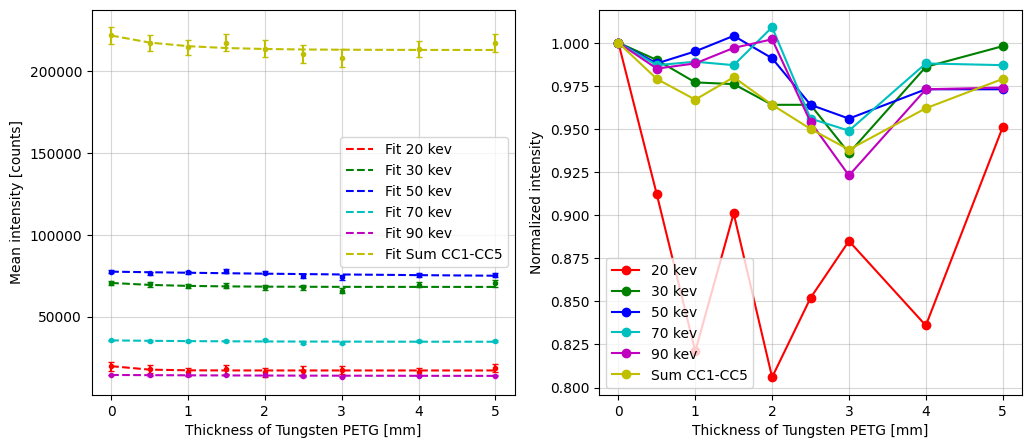

In [19]:
from scipy.optimize import curve_fit
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
bin_range = [0,1,2,3,4,6]
for i, bin_id in enumerate(bin_range): # skip bin 5

    df_bin = df[df["bin_id"] == bin_id]
    start_idx = 0
    thickness = df_bin["thickness"][start_idx:] 
    T_mean = df_bin["T_mean"][start_idx:] 
    T_std = df_bin["T_error"][start_idx:] 
    T_mean_norm = df_bin["T_mean_norm"][start_idx:] 
    T_std_norm = df_bin["T_std"]/df_bin["T_mean"].values[0]

    I0 = df_bin["I0_fit"].values[0]
    mu = df_bin["mu_fit"].values[0]
    offset = df_bin["offset_fit"].values[0]
    popt = [I0, mu, offset]

    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    ax[0].errorbar(
        thickness, T_mean, yerr=T_std,
        capsize=2, 
        fmt = ".",
        # label=f"Raw data {BIN_LABELS[bin_id]}",
        color = colors[i]
    )
    
    ax[0].plot(thickness, Intensity(thickness, *popt), "--",
               label=f"Fit {BIN_LABELS[bin_id]}",
               color = colors[i])
    
    ax[1].plot(thickness, T_mean_norm, "-o", 
               label=f"{BIN_LABELS[bin_id]}",
               color = colors[i])

    # make plots look nice 
    ax[0].set_xlabel("Thickness of Tungsten PETG [mm]")
    ax[0].set_ylabel("Mean intensity [counts]")
    ax[0].legend()
    ax[0].grid(True, alpha=0.5)
    ax[1].set_xlabel("Thickness of Tungsten PETG [mm]")
    ax[1].set_ylabel("Normalized intensity")
    ax[1].grid(True, alpha = 0.5)
    ax[1].legend()

plt.show()
    

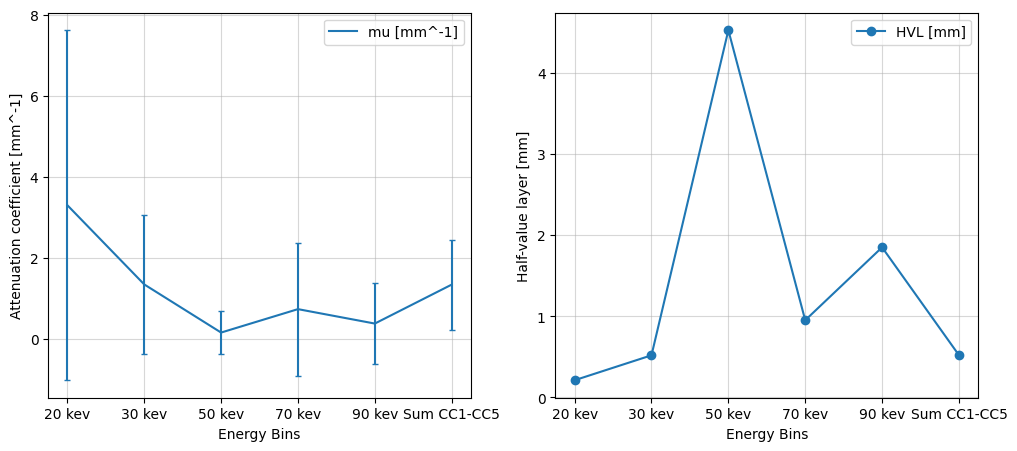

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
df_params.plot(x="bin_label", y="mu [mm^-1]", kind="line", yerr="mu_err", capsize=2, ax=ax[0])
df_params.plot(x="bin_label", y="HVL [mm]", kind="line", marker='o', ax=ax[1])
ax[0].set_ylabel("Attenuation coefficient [mm^-1]")
ax[0].set_xlabel("Energy Bins")
ax[1].set_ylabel("Half-value layer [mm]")
ax[1].set_xlabel("Energy Bins")
ax[0].grid(True, alpha=0.5)
ax[1].grid(True, alpha=0.5)
plt.show()

## Plotly figures

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)

for bin_id in [0,1,2,3,4,6]: # skip bin 5

    df_bin = df[df["bin_id"] == bin_id]
    thickness = df_bin["thickness"]
    T_mean = df_bin["T_mean"]
    T_std = df_bin["T_error"]
    T_mean_norm = df_bin["T_mean_norm"]
    T_std_norm = df_bin["T_std"]/df_bin["T_mean"].values[0]
    
    fig.add_trace(
        go.Scatter(
            x=thickness,
            y=T_mean,
            error_y=dict(
                type="data",
                array=T_std,
                visible=True,
            ),
            mode="lines",
            name=BIN_LABELS[bin_id],
        ),
        row=1, col=1,
    )
    
    fig.add_trace(
        go.Scatter(
            x=thickness,
            y=T_mean_norm,
            error_y=dict(
                type="data",
                array=T_std_norm,
                visible=True,
            ),
            mode="lines",
            name=BIN_LABELS[bin_id],
        ),
        row=1, col=2,
    )

fig.update_layout(
    xaxis_title="Thickness of Tungsten PETG [mm]",
    yaxis_title="Mean transmission",
    showlegend=True,
)

fig.update_layout(height=600, width=1200)
fig.show()
